## NYPD Data

### Imports

In [ ]:
# data import
import pickle

# data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# plotting
import matplotlib.pyplot as plt

#gaussian filter
from scipy.ndimage import gaussian_filter

### Data Import

In [ ]:
pickle_path = ('../raw_data/clean.pickle')
with open(pickle_path, 'rb') as f:
    df = pickle.load(f)

### Sample Selection

In [ ]:
inf = df['period'] > datetime(2016, 10, 1, 0, 0, 0)
sup = df['period'] < datetime(2017, 10, 1, 0, 0, 0)
sample = df[ inf & sup ]
sample = sample[sample['borough']=='BROOKLYN']

In [27]:
sample.shape

(137912, 20)

### Lat - Long to Array

In [14]:
def from_meters_to_coords(lat_meters, lon_meters):
    """
    gives the latitude and longitude step to use for the grid buckets
    lat_meters, lon_meters = lat/lon step
    """
    #Position, decimal degrees
    lat = 40
    lon = -73

    #Earth’s radius, sphere
    R=6378137

    #offsets in meters
    dn = lat_meters
    de = lon_meters

    #Coordinate offsets in radians
    dLat = dn/R
    dLon = de/(R*np.cos(np.pi*lat/180))

    #OffsetPosition, decimal degrees
    latO = dLat * 180/np.pi
    lonO = dLon * 180/np.pi 

    return latO, lonO

In [61]:
def from_coord_to_matrix(df, lat_meters, lon_meters):
    """
    outputs the 3D matrix of all coordinates for a given bucket height and width in meters
    """
    df=df.copy()
    #add 'time_index' column to df
    ind = {time:index for index,time in enumerate(np.sort(df['period'].unique()))}
    df['time_index'] = df['period'].map(ind)
    
    #initiate matrix
    #([40.56952999448672, 40.73912795313436],[-74.04189660705046, -73.83355923946421]) : brooklyn boundaries
    
    grid_offset = np.array([ -40.73912795313436,  -74.04189660705046,0]) # Where do you start
    #from meters to lat/lon step
    lat_spacing, lon_spacing = from_meters_to_coords(lat_meters, lon_meters )
    grid_spacing = np.array([lat_spacing , lon_spacing,1]) # What's the space you consider (euclidian here)
     
    
    #get points coordinates
    coords = np.array([( -lat, lon,t_ind) for lat, lon,t_ind \
                   in zip(df['latitude'],df['longitude'],df['time_index'])])
    
    
    # Convert point to index
    indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
    X = indexes[:,0]
    Y = indexes[:,1]
    Z = indexes[:,2]
    
    #virgin matrix
    a = np.zeros((X.max()+1, Y.max()+1, Z.max()+1))
   
    
    a[X, Y, Z]=1
    
    return a, a.shape[1], a.shape[2]

In [68]:
img, lat_size, lon_size = from_coord_to_matrix(sample, 50, 50)

In [69]:
img.shape

(373, 317, 8748)

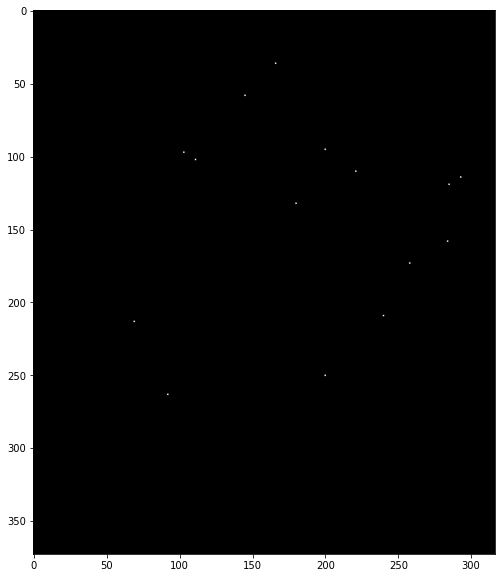

In [70]:
plt.figure(figsize=(10, 10))

plt.imshow(img[:,:,10], cmap='gray');

### Plotting Array (with and w/o Gaussian filter)

In [ ]:
#plt.figure(figsize=(5, 5))
#plt.imshow(img[3], cmap='gray');

In [71]:
img3D_conv = gaussian_filter(img, sigma=(2, 2, 2))

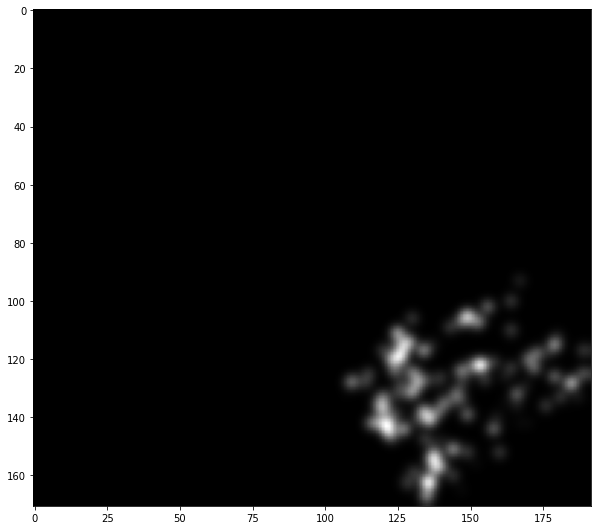

In [51]:
plt.figure(figsize=(10, 10))

plt.imshow(img3D_conv[:,:,4], cmap='gray');

### Splitting into X and y

In [73]:
def get_observation_target(img3D_conv, x_length, y_length):
    '''
    output an observation of x_length consecutive images and the y_length next images as the target
    '''
    position = np.random.randint(0, img3D_conv.shape[0] - (x_length + y_length))
    observation = img3D_conv[:,:,position:position + x_length]
    target = img3D_conv[:,:,position + x_length:position + (x_length + y_length)]

    return observation, target

### Subsampling to get multiple X and y

In [74]:
def get_X_y(img3D_conv, number_of_observations, x_length, y_length):
    '''
    outputs n observations and their associated targets
    '''
    X = []
    y = []
    
    for n in range(number_of_observations):
        X_subsample, y_subsample = get_observation_target(img3D_conv, x_length, y_length)
        X.append(X_subsample)
        y.append(y_subsample)
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [75]:
x_length = 24
y_length= 3

X, y = get_X_y(img3D_conv, 1000, x_length, y_length)

In [76]:
X.shape

(1000, 373, 317, 24)

## Model

### Imports

In [77]:
# Train, test, split
from sklearn.model_selection import train_test_split

# Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

### Train, test, split

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Model

In [79]:
def init_model(x_length, y_length, lat_size, lon_size):
    print('initializing model')
    model = models.Sequential()
    
    print('adding conv2D 1')
    model.add(layers.Conv2D(256, kernel_size = 10, activation = 'relu', padding='same',
                            input_shape = (x_length, lat_size, lon_size)))
    model.add(layers.MaxPooling2D(2))

    print('adding conv2D 2')
    model.add(layers.Conv2D(128, kernel_size = 5, activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(2))

    print('adding conv2D 3')
    model.add(layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(2,))     

    print('flattening')
    model.add(layers.Flatten())
    
    print('adding dense layer 1')
    model.add(layers.Dense(500, activation = 'relu'))
    
    print('adding dense layer 1')
    model.add(layers.Dense(5000, activation = 'relu'))
    
    print('adding dense layer 2')
    model.add(layers.Dense(lat_size * lon_size, activation = 'relu'))
    
    #print('adding dense layer 2')
    #model.add(layers.Dropout(rate=0.5))

    print('adding final dense layer')
    model.add(layers.Dense(y_length * lat_size * lon_size, activation = 'relu'))
    
    print('Reshaping')
    model.add(layers.Reshape((lat_size, lon_size, y_length)))
    
    print('compiling')
    model.compile(loss = 'mse',
                  optimizer = 'adam',
                  metrics = 'mae')
    print('Done !')
    
    return model

### Running Model (Instance, Early Stopping, Fit and Evaluate)

**Reminders**

**batch_size:** no. of data used to compute error between y_pred and y_true each time weights of neural network updated (use 16 or 32)

**epoch:** once all data has been used once to update the weights

In [ ]:
model = init_model(x_length,y_length, lat_size, lon_size)

initializing model
adding conv2D 1
adding conv2D 2
adding conv2D 3
flattening
adding dense layer 1
adding dense layer 1
adding dense layer 2


In [ ]:
model.summary()

In [ ]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                      batch_size = 32, 
                      epochs = 2,
                      validation_split = 0.3,
                      callbacks = es)

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['val_mae'])

In [ ]:
print(model.evaluate(X_test, y_test))

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = flatten

In [ ]:
y_pred.reshape(y_length, lat_size, lon_size)

## From coord to map

In [ ]:
def from_matrix_to_coord(matrix, lat_meters, lon_meters):
        """
        gives back the coordinates from a 3D matrix for a given bucket height and width
        """
        results = []
        for observation in matrix:
            # Where do you start
            grid_offset = np.array([0, -40.91553277600008,  -74.25559136315213,])

            #from meters to lat/lon step
            lat_spacing, lon_spacing = from_meters_to_coords(lat_meters, lon_meters)

            # What's the space you consider (euclidian here)
            grid_spacing = np.array([1, lat_spacing, lon_spacing])

            indexes = np.argwhere(observation)
            #print(indexes.shape)
            # index : coords de mes crimes dans mon np array
            result = grid_offset + indexes * grid_spacing
            results.append(result)
        return np.array(results)

In [ ]:
y_pred_notsure = np.where((y_train>5*10**(-4)) & (y_train<5*10**(-3)), y_train, 0)
y_pred_middle = np.where((y_train>5*10**(-3)) & (y_train<1*10**(-2)), y_train, 0)
y_pred_sure = np.where(y_train>1*10**(-2), y_train, 0)

#y_pred_notsure = np.where((y_pred>5*10**(-3)) & (y_pred<1*10**(-2)), y_pred, 0)
#y_pred_middle = np.where((y_pred>1*10**(-2)) & (y_pred<1.8*10**(-2)), y_pred, 0)
#y_pred_sure = np.where(y_pred>1.8*10**(-2), y_pred, 0)

In [ ]:
coords_not_sure = from_matrix_to_coord(y_pred_notsure, 200, 200)
coords_middle = from_matrix_to_coord(y_pred_middle, 200, 200)
coords_sure = from_matrix_to_coord(y_pred_sure, 200, 200)

In [ ]:
coords_back_not_sure_df = pd.DataFrame(coords_not_sure[0], columns=['image', 'lat', 'lon'])
coords_back_not_sure_df['right_lat'] = -coords_back_not_sure_df['lat']

coords_middle_df = pd.DataFrame(coords_middle[0], columns=['image', 'lat', 'lon'])
coords_middle_df['right_lat'] = -coords_middle_df['lat']

coords_back_sure_df = pd.DataFrame(coords_sure[0], columns=['image', 'lat', 'lon'])
coords_back_sure_df['right_lat'] = -coords_back_sure_df['lat']

In [ ]:
last_image_not_sure = coords_back_not_sure_df[coords_back_not_sure_df['image']==2.0]
last_image_middle = coords_middle_df[coords_middle_df['image']==2.0]
last_image_sure = coords_back_sure_df[coords_back_sure_df['image']==2.0]

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim(left=-74.25559136315213, right=-73.70000906387347)
ax.set_ylim(bottom = 40.49611539518921, top=40.91553277600008)
sns.scatterplot(x='lon', y='right_lat', data=last_image_not_sure, s=2, ax=ax)
sns.scatterplot(x='lon', y='right_lat', data=last_image_middle, s=2, ax=ax)
sns.scatterplot(x='lon', y='right_lat', data=last_image_sure, s=2, ax=ax)
plt.legend()

In [ ]:
#modèle clairement pourri car il indique des crimes sur staten island
#voir baseline modèle (on est en dessous)